# GRASS GIS Tutorial - Advanced Terrain Analysis

## Overview

GRASS GIS (Geographic Resources Analysis Support System) is one of the oldest and most comprehensive open-source GIS platforms, with over 500 modules for raster, vector, and 3D analysis.

## What You'll Learn

This tutorial covers GRASS GIS terrain analysis capabilities including Terrain Ruggedness Index (TRI) using neighborhood statistics, Topographic Position Index (TPI) for landform classification, Slope and Aspect with proper handling of geographic coordinates, and Surface Roughness using elevation range analysis.

## Prerequisites

This notebook requires the `watershed_dem.tif` file created by running Notebook 03 (Watershed Delineation). The configuration file `watershed_analysis.json` from Notebook 01 must also be present.

## Setup: Load Configuration and Imports

In [17]:
import json
import os
import subprocess
import tempfile
import shutil
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import warnings
warnings.filterwarnings('ignore')

# Load configuration
with open('watershed_analysis.json', 'r') as f:
    config = json.load(f)

# Create output directories
os.makedirs(config["temp_dir"], exist_ok=True)
os.makedirs(config["output_dir"], exist_ok=True)

# Use watershed DEM (output of Step 03)
watershed_dem = os.path.join(config['output_dir'], 'watershed_dem.tif')
if not os.path.exists(watershed_dem):
    raise FileNotFoundError(
        "watershed_dem.tif not found - run 03_Watershed_Delineation first!"
    )

print("Configuration loaded")
print(f"Watershed DEM: {watershed_dem}")
print(f"Output directory: {config['output_dir']}")

Configuration loaded
Watershed DEM: results/watershed_dem.tif
Output directory: results


## Preprocessing: Reproject DEM to UTM

For accurate terrain analysis, the DEM should be in a projected coordinate system with meters as the unit. This cell reprojects the watershed DEM from geographic coordinates (degrees) to UTM Zone 45N (EPSG:32645).

In [18]:
print("Preprocessing: Reprojecting DEM to UTM...\n")

# Reproject DEM to UTM meters (EPSG:32645)
watershed_dem_utm = os.path.join(config['output_dir'], 'watershed_dem_utm.tif')

# Check if already exists from SAGA notebook
if not os.path.exists(watershed_dem_utm):
    subprocess.run([
        "gdalwarp",
        "-t_srs", "EPSG:32645",
        "-r", "bilinear",
        "-overwrite",
        "-of", "GTiff",
        watershed_dem,
        watershed_dem_utm
    ], check=True)
    print(f"Reprojected DEM saved to: {watershed_dem_utm}")
else:
    print(f"Using existing UTM DEM: {watershed_dem_utm}")

# Print info
with rasterio.open(watershed_dem_utm) as src:
    print(f"\nDEM Info:")
    print(f"  CRS: {src.crs}")
    print(f"  Resolution: {src.res[0]:.2f} m")
    print(f"  Bounds: {src.bounds}")

Preprocessing: Reprojecting DEM to UTM...

Using existing UTM DEM: results/watershed_dem_utm.tif

DEM Info:
  CRS: EPSG:32645
  Resolution: 28.12 m
  Bounds: BoundingBox(left=-140482.12713386572, bottom=3267729.3971067015, right=-108708.48229046552, top=3290224.012925038)


## Helper Functions for GRASS GIS

This cell defines the GRASSSession class which manages temporary GRASS locations and provides methods for running GRASS modules. The `visualize_raster()` function creates matplotlib visualizations with correct axis labels based on the coordinate reference system.

In [43]:
class GRASSSession:
    """
    Context manager for GRASS GIS sessions
    """
    
    def __init__(self, dem_path):
        self.dem_path = dem_path
        self.temp_dir = None
        self.gisdbase = None
        self.location = "temp_location"
        self.mapset = "PERMANENT"
        self.env = None
        
    def __enter__(self):
        """Set up GRASS environment"""
        self.temp_dir = tempfile.mkdtemp(prefix="grass_")
        self.gisdbase = os.path.join(self.temp_dir, "grassdb")
        permanent_dir = os.path.join(self.gisdbase, self.location, self.mapset)
        os.makedirs(permanent_dir)
        
        gisrc = os.path.join(self.temp_dir, "gisrc")
        with open(gisrc, 'w') as f:
            f.write(f"GISDBASE: {self.gisdbase}\n")
            f.write(f"LOCATION_NAME: {self.location}\n")
            f.write(f"MAPSET: {self.mapset}\n")
        
        with open(os.path.join(permanent_dir, "DEFAULT_WIND"), 'w') as f:
            f.write("proj: 0\nzone: 0\nnorth: 1\nsouth: 0\neast: 1\nwest: 0\n")
            f.write("cols: 1\nrows: 1\ne-w resol: 1\nn-s resol: 1\ntop: 1\nbottom: 0\n")
        
        shutil.copy2(
            os.path.join(permanent_dir, "DEFAULT_WIND"),
            os.path.join(permanent_dir, "WIND")
        )
        
        self.env = os.environ.copy()
        self.env['GISRC'] = gisrc
        self.env['GISBASE'] = config["grass_bin"][:-4]
        self.env['PATH'] = f'{config["grass_bin"]}:{config["grass_bin"]}:/usr/local/bin:/usr/bin:/bin'
        self.env['LD_LIBRARY_PATH'] = f'{config["grass_bin"][:-4]}/lib'
        self.env['GDAL_DATA'] = config["gdal_data_path"]
        self.env['PROJ_LIB'] = config["proj_lib_path"]
        self.env['GDAL_DRIVER_PATH'] = 'disable'
        self.env['LC_ALL'] = config["locale"]
        
        self._run_command([
            f'{config["grass_bin"]}/r.in.gdal',
            f'input={self.dem_path}',
            'output=dem',
            '--overwrite',
            '-o'
        ])
        
        self._run_command([
            f'{config["grass_bin"]}/g.region',
            'raster=dem'
        ])
        
        print("GRASS session initialized")
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        """Clean up GRASS environment"""
        if self.temp_dir and os.path.exists(self.temp_dir):
            shutil.rmtree(self.temp_dir)
        print("GRASS session closed")
    
    def _run_command(self, cmd, capture_output=True, check=True):
        """Run a GRASS command"""
        result = subprocess.run(
            cmd,
            env=self.env,
            capture_output=capture_output,
            text=True,
            check=check
        )
        return result
    
    def run_module(self, module, parameters, verbose=False):
        """
        Execute a GRASS module
        """
        if module == 'r.mapcalc' and isinstance(parameters, str):
            cmd = [f'{config["grass_bin"]}/{module}', f'expression={parameters}', '--overwrite']
        else:
            cmd = [f'{config["grass_bin"]}/{module}'] + parameters + ['--overwrite']
        
        if verbose:
            print(f"Running: {' '.join(cmd)}")
        
        result = self._run_command(cmd)
        return result
    
    def export_raster(self, raster_name, output_path):
        """
        Export a GRASS raster to GeoTIFF
        """
        self._run_command([
            f'{config["grass_bin"]}/r.out.gdal',
            f'input={raster_name}',
            f'output={output_path}',
            '--overwrite'
        ])


def visualize_raster(file_path, title, cmap='viridis', figsize=(10, 8), percentile=(2, 98)):
    """
    Visualize a raster file with matplotlib
    """
    with rasterio.open(file_path) as src:
        data = src.read(1, masked=True)
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        crs = src.crs
    
    # Handle aspect differently (circular data)
    if 'Aspect' in title:
        vmin, vmax = 0, 360
    else:
        valid_data = data[~data.mask] if hasattr(data, 'mask') else data[~np.isnan(data)]
        if len(valid_data) > 0:
            vmin, vmax = np.percentile(valid_data, percentile)
        else:
            vmin, vmax = np.nanmin(data), np.nanmax(data)
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(data, cmap=cmap, extent=extent, aspect='equal', vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=13, fontweight='bold', pad=12)
    
    # Set axis labels based on CRS
    if crs and crs.is_projected:
        ax.set_xlabel('Easting (m)', fontsize=10)
        ax.set_ylabel('Northing (m)', fontsize=10)
    else:
        ax.set_xlabel('Easting (m)', fontsize=10)
        ax.set_ylabel('Northing (m)', fontsize=10)
    
    ax.ticklabel_format(style='plain', useOffset=False)
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right', fontsize=9)
    plt.setp(ax.get_yticklabels(), fontsize=9)
    
    cbar = plt.colorbar(im, ax=ax, shrink=0.5, pad=0.03)
    cbar.ax.tick_params(labelsize=9)
    
    plt.tight_layout()
    plt.show()
    plt.close()


def compute_statistics(file_path):
    """
    Compute basic statistics for a raster file
    """
    with rasterio.open(file_path) as src:
        data = src.read(1, masked=True)
    
    valid_data = data[~data.mask] if hasattr(data, 'mask') else data[~np.isnan(data)]
    
    return {
        'min': np.min(valid_data) if len(valid_data) > 0 else np.nan,
        'max': np.max(valid_data) if len(valid_data) > 0 else np.nan,
        'mean': np.mean(valid_data) if len(valid_data) > 0 else np.nan,
        'std': np.std(valid_data) if len(valid_data) > 0 else np.nan,
        'median': np.median(valid_data) if len(valid_data) > 0 else np.nan
    }


print("Helper functions loaded")

Helper functions loaded


## 1. Terrain Ruggedness Index (TRI)

The Terrain Ruggedness Index quantifies terrain heterogeneity by calculating the standard deviation of elevation values within a neighborhood. High values indicate rugged, variable terrain while low values indicate smooth, uniform terrain.

**GRASS Module**: `r.neighbors` with method=stddev

In [44]:
print("Calculating Terrain Ruggedness Index (TRI)...\n")

tri_file = os.path.join(config['output_dir'], 'grass_tri.tif')

# Use the UTM-projected DEM
with GRASSSession(watershed_dem_utm) as grass:
    grass.run_module(
        module='r.neighbors',
        parameters=[
            'input=dem',
            'output=tri',
            'method=stddev',
            'size=3'
        ]
    )
    grass.export_raster('tri', tri_file)

print(f"TRI saved to: {tri_file}\n")

stats = compute_statistics(tri_file)
print("TRI Statistics:")
print(f"  Min:    {stats['min']:.2f}")
print(f"  Max:    {stats['max']:.2f}")
print(f"  Mean:   {stats['mean']:.2f}")
print(f"  Median: {stats['median']:.2f}")

Calculating Terrain Ruggedness Index (TRI)...

GRASS session initialized
GRASS session closed
TRI saved to: results/grass_tri.tif

TRI Statistics:
  Min:    0.00
  Max:    58.59
  Mean:   12.99
  Median: 12.73


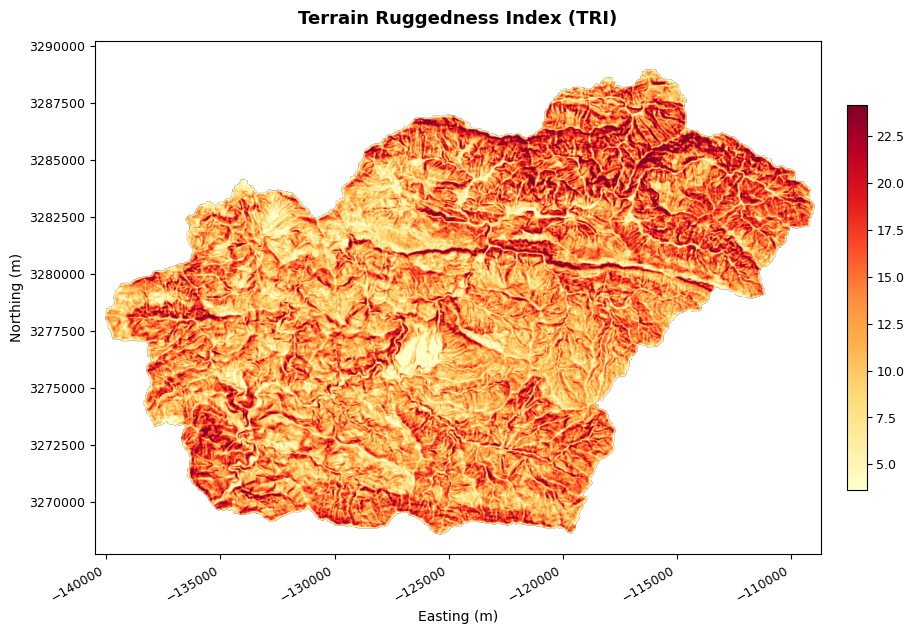

In [45]:
visualize_raster(
    tri_file,
    title='Terrain Ruggedness Index (TRI)',
    cmap='YlOrRd',
    percentile=(2, 98)
)

## 2. Topographic Position Index (TPI)

The Topographic Position Index compares each cell's elevation to the mean elevation of surrounding cells. Positive values indicate ridges and hilltops (higher than surroundings). Negative values indicate valleys and depressions (lower than surroundings). Values near zero indicate flat areas or mid-slopes.

**GRASS Modules**: `r.neighbors` (mean) + `r.mapcalc` (difference)

In [46]:
print("Calculating Topographic Position Index (TPI)...\n")

tpi_file = os.path.join(config['output_dir'], 'grass_tpi.tif')

# Use the UTM-projected DEM
with GRASSSession(watershed_dem_utm) as grass:
    grass.run_module(
        module='r.neighbors',
        parameters=[
            'input=dem',
            'output=dem_mean',
            'method=average',
            'size=3'
        ]
    )
    
    grass.run_module(
        module='r.mapcalc',
        parameters='tpi = dem - dem_mean'
    )
    
    grass.export_raster('tpi', tpi_file)

print(f"TPI saved to: {tpi_file}\n")

stats = compute_statistics(tpi_file)
print("TPI Statistics:")
print(f"  Min:    {stats['min']:.2f}")
print(f"  Max:    {stats['max']:.2f}")
print(f"  Mean:   {stats['mean']:.2f}")
print(f"  Median: {stats['median']:.2f}")

Calculating Topographic Position Index (TPI)...

GRASS session initialized
GRASS session closed
TPI saved to: results/grass_tpi.tif

TPI Statistics:
  Min:    -20.43
  Max:    18.43
  Mean:   0.01
  Median: 0.07


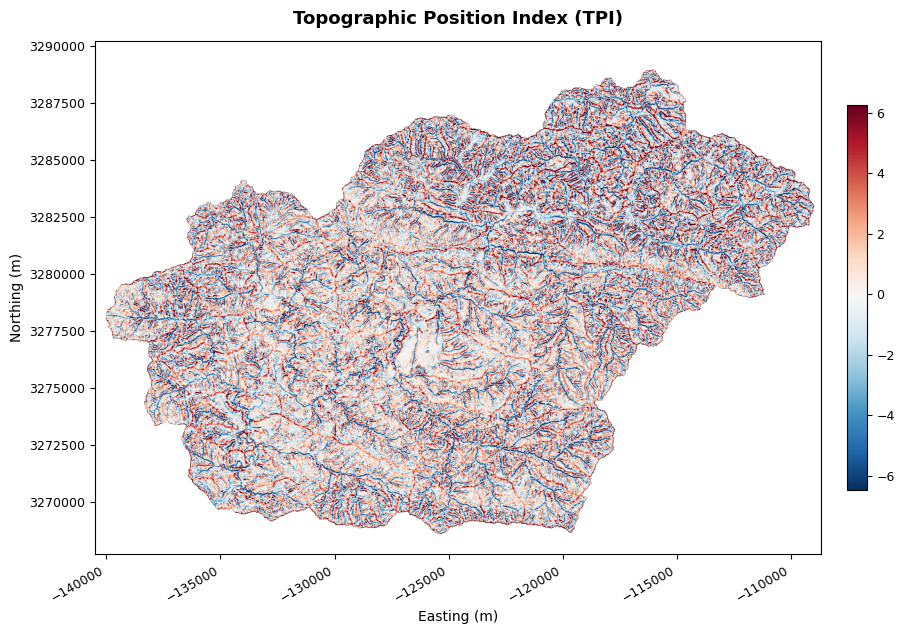

In [47]:
visualize_raster(
    tpi_file,
    title='Topographic Position Index (TPI)',
    cmap='RdBu_r',
    percentile=(2, 98)
)

## 3. Slope and Aspect

**Slope** measures terrain steepness in degrees. **Aspect** indicates the compass direction that a slope faces. With projected coordinates (UTM), no zscale correction is needed since x, y, and z are all in meters.

**GRASS Module**: `r.slope.aspect`

In [48]:
print("Calculating Slope and Aspect...\n")

slope_file = os.path.join(config['output_dir'], 'grass_slope.tif')
aspect_file = os.path.join(config['output_dir'], 'grass_aspect.tif')

# Use the UTM-projected DEM (no zscale correction needed)
with GRASSSession(watershed_dem_utm) as grass:
    # Mask NoData values
    grass.run_module(
        module='r.mapcalc',
        parameters='dem_clean = if(dem == -9999, null(), dem)'
    )
    
    # Calculate slope and aspect
    grass.run_module(
        module='r.slope.aspect',
        parameters=[
            'elevation=dem_clean',
            'slope=slope',
            'aspect=aspect',
            'format=degrees'
        ]
    )
    
    grass.export_raster('slope', slope_file)
    grass.export_raster('aspect', aspect_file)

print(f"Slope saved to: {slope_file}")
print(f"Aspect saved to: {aspect_file}\n")

slope_stats = compute_statistics(slope_file)
print("Slope Statistics:")
print(f"  Min:    {slope_stats['min']:.2f} degrees")
print(f"  Max:    {slope_stats['max']:.2f} degrees")
print(f"  Mean:   {slope_stats['mean']:.2f} degrees")
print(f"  Median: {slope_stats['median']:.2f} degrees")

Calculating Slope and Aspect...

GRASS session initialized
GRASS session closed
Slope saved to: results/grass_slope.tif
Aspect saved to: results/grass_aspect.tif

Slope Statistics:
  Min:    0.12 degrees
  Max:    68.98 degrees
  Mean:   28.30 degrees
  Median: 28.76 degrees


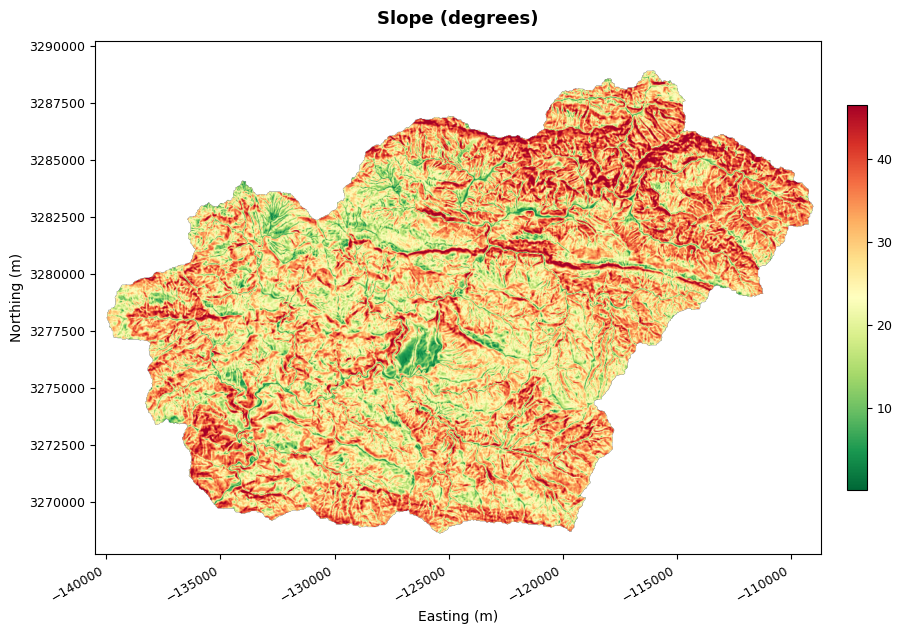

In [49]:
visualize_raster(
    slope_file,
    title='Slope (degrees)',
    cmap='RdYlGn_r',
    percentile=(0, 98)
)

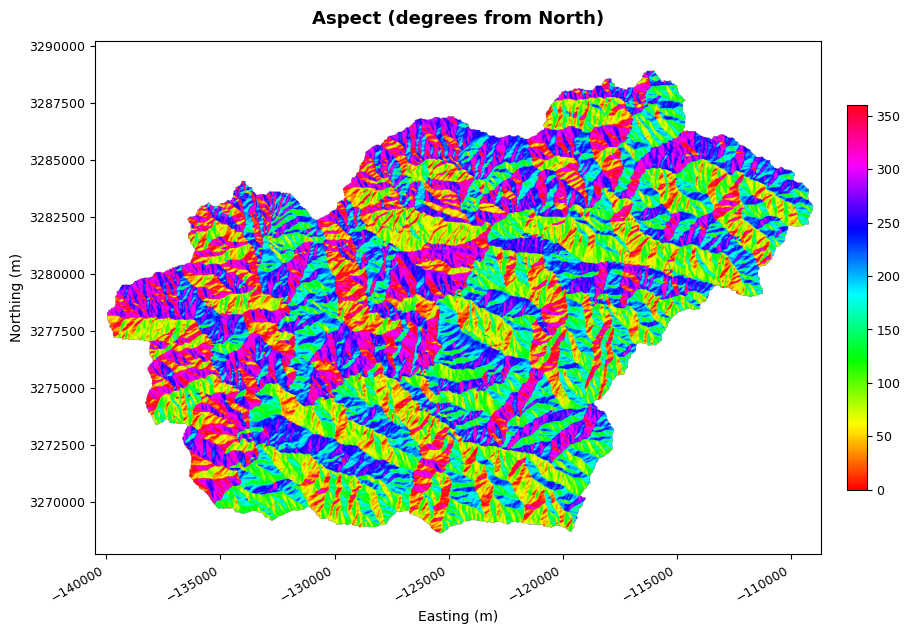

In [50]:
visualize_raster(
    aspect_file,
    title='Aspect (degrees from North)',
    cmap='hsv',
    percentile=(0, 100)
)

## 4. Surface Roughness

Surface roughness is calculated as the range (maximum minus minimum) of elevation values within a 3x3 neighborhood. High values indicate rough terrain with large local elevation differences while low values indicate smooth terrain.

**GRASS Module**: `r.neighbors` with method=range

In [51]:
print("Calculating Surface Roughness...\n")

roughness_file = os.path.join(config['output_dir'], 'grass_roughness.tif')

# Use the UTM-projected DEM
with GRASSSession(watershed_dem_utm) as grass:
    # Mask NoData values
    grass.run_module(
        module='r.mapcalc',
        parameters='dem_clean = if(dem == -9999, null(), dem)'
    )
    
    # Calculate surface roughness
    grass.run_module(
        module='r.neighbors',
        parameters=[
            'input=dem_clean',
            'output=roughness',
            'method=range',
            'size=3'
        ]
    )
    
    grass.export_raster('roughness', roughness_file)

print(f"Roughness saved to: {roughness_file}\n")

stats = compute_statistics(roughness_file)
print("Surface Roughness Statistics:")
print(f"  Min:    {stats['min']:.2f}")
print(f"  Max:    {stats['max']:.2f}")
print(f"  Mean:   {stats['mean']:.2f}")
print(f"  Median: {stats['median']:.2f}")

Calculating Surface Roughness...

GRASS session initialized
GRASS session closed
Roughness saved to: results/grass_roughness.tif

Surface Roughness Statistics:
  Min:    0.00
  Max:    178.51
  Mean:   40.46
  Median: 39.46


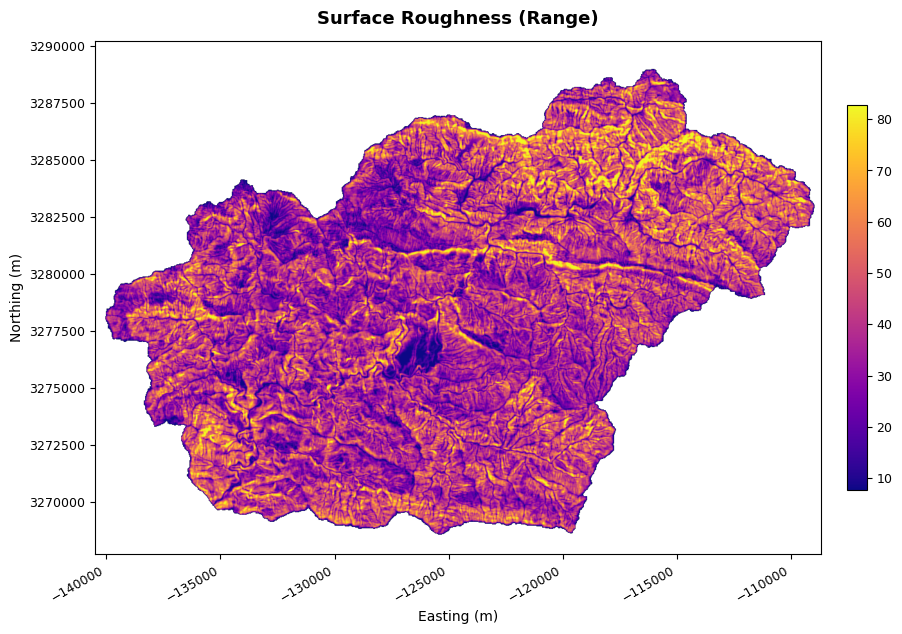

In [52]:
visualize_raster(
    roughness_file,
    title='Surface Roughness (Range)',
    cmap='plasma',
    percentile=(1, 99)
)

## Comparative Visualization

This cell creates a comprehensive comparison of all GRASS terrain metrics side-by-side.

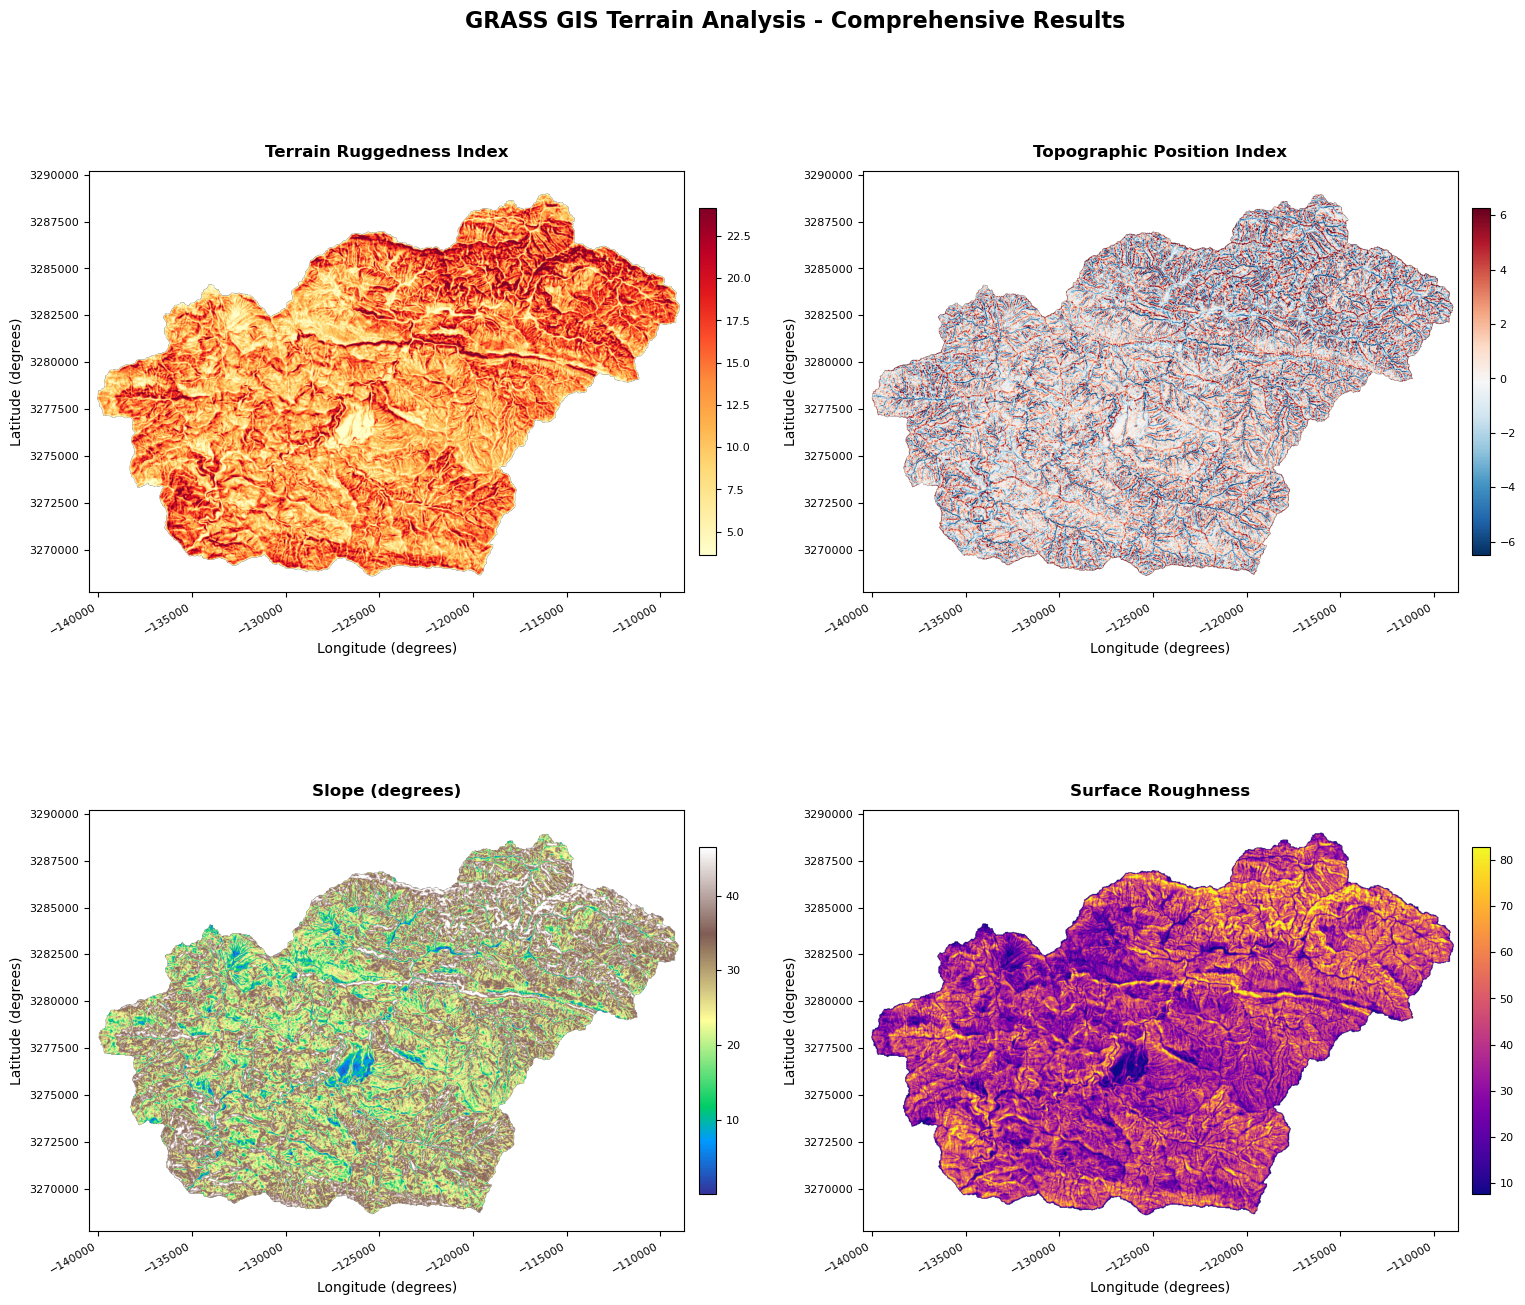


Comparison saved to: results/grass_terrain_comparison.png


In [53]:
# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('GRASS GIS Terrain Analysis - Comprehensive Results', 
             fontsize=16, fontweight='bold', y=0.98)

datasets = [
    (tri_file, 'Terrain Ruggedness Index', 'YlOrRd', (2, 98)),
    (tpi_file, 'Topographic Position Index', 'RdBu_r', (2, 98)),
    (slope_file, 'Slope (degrees)', 'terrain', (0, 98)),
    (roughness_file, 'Surface Roughness', 'plasma', (1, 99))
]

axes = axes.flatten()

for idx, (filepath, title, cmap, percentiles) in enumerate(datasets):
    if os.path.exists(filepath):
        with rasterio.open(filepath) as src:
            data = src.read(1, masked=True)
            extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
            crs = src.crs
        
        valid_data = data[~data.mask] if hasattr(data, 'mask') else data[~np.isnan(data)]
        
        if len(valid_data) > 0:
            vmin, vmax = np.percentile(valid_data, percentiles)
        else:
            vmin, vmax = np.nanmin(data), np.nanmax(data)
        
        im = axes[idx].imshow(data, cmap=cmap, extent=extent, aspect='equal', 
                             vmin=vmin, vmax=vmax)
        
        axes[idx].set_title(title, fontsize=12, fontweight='bold', pad=10)
        
        # Set axis labels based on CRS
        if crs and crs.is_projected:
            axes[idx].set_xlabel('Easting (m)', fontsize=10)
            axes[idx].set_ylabel('Northing (m)', fontsize=10)
        else:
            axes[idx].set_xlabel('Longitude (degrees)', fontsize=10)
            axes[idx].set_ylabel('Latitude (degrees)', fontsize=10)
        
        axes[idx].ticklabel_format(style='plain', useOffset=False)
        plt.setp(axes[idx].get_xticklabels(), rotation=30, ha='right', fontsize=8)
        plt.setp(axes[idx].get_yticklabels(), fontsize=8)
        
        cbar = plt.colorbar(im, ax=axes[idx], shrink=0.5, pad=0.02)
        cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
comparison_file = os.path.join(config['output_dir'], 'grass_terrain_comparison.png')
plt.savefig(comparison_file, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"\nComparison saved to: {comparison_file}")

## Summary Statistics

In [55]:
import pandas as pd

stats_data = []

metrics = [
    (tri_file, 'Terrain Ruggedness Index'),
    (tpi_file, 'Topographic Position Index'),
    (slope_file, 'Slope (degrees)'),
    (roughness_file, 'Surface Roughness')
]

for filepath, metric_name in metrics:
    if os.path.exists(filepath):
        stats = compute_statistics(filepath)
        stats_data.append({
            'Metric': metric_name,
            'Min': f"{stats['min']:.2f}",
            'Max': f"{stats['max']:.2f}",
            'Mean': f"{stats['mean']:.2f}",
            'Median': f"{stats['median']:.2f}"
        })

stats_df = pd.DataFrame(stats_data)
print("\nGRASS Terrain Metrics Summary:")
print(stats_df.to_string(index=False))


GRASS Terrain Metrics Summary:
                    Metric    Min    Max  Mean Median
  Terrain Ruggedness Index   0.00  58.59 12.99  12.73
Topographic Position Index -20.43  18.43  0.01   0.07
           Slope (degrees)   0.12  68.98 28.30  28.76
         Surface Roughness   0.00 178.51 40.46  39.46


## Summary

This tutorial demonstrated GRASS GIS terrain analysis capabilities using the UTM-projected watershed DEM. TRI quantifies terrain variability using neighborhood standard deviation. TPI identifies ridges (positive) versus valleys (negative) based on relative elevation. Slope and Aspect provide fundamental terrain derivatives with proper coordinate handling. Surface Roughness measures local elevation range.

GRASS GIS provides powerful neighborhood analysis through `r.neighbors` and flexible raster math via `r.mapcalc`. These metrics complement the SAGA GIS analyses from Notebook 04 and can be used together for comprehensive terrain characterization.